## Standardization of metrics (area, length, width, perimeter) of seeds of favabeans with coin as standard using metadata file and masks generated by SegmentAnything (Meta)

__author__="harpreet kaur bargota"

__email__="harpreet.bargota@agr.gc.ca"

__Project__="WGRF - Image Classification pipeline for Faba beans"

#### Pre-requisite criteria: 
##### This python file uses the metadata file (metadata.csv) of SAM masks and the binary masks (*.png) for each image, generated after running SegmentAnything model on the images.
##### The images should have run already been run on SAM model and the resultant metadata .csv file and the individual binary masks generated by automatic mask generation method.


In [1]:
#import the various libraries and its dependencies
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.util import crop
import warnings
warnings.filterwarnings("ignore")

C:\Users\bargotah\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


For visualization purposes, only 1 image (Faba-Seed-CC_Vf2-1-1.JPG) has been used. The metadata .csv and binary masks (*.png) were used from the output folder 

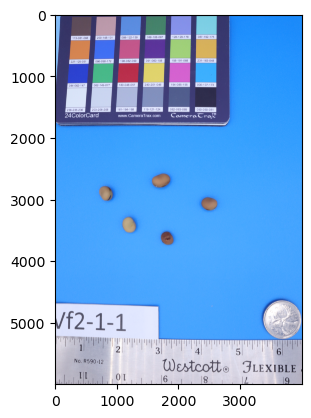

In [2]:
#Read the image. For demonstrating the example, just a single image has been used but the process would be the same for each image in pipeline

#read the image from path where it is located
image=cv2.imread(r"C:\Users\bargotah\Downloads\output_cropmask\Faba-Seed-CC_Vf2-1-1.JPG") 
#convert the image to RGB format and plot to visualize
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(image)

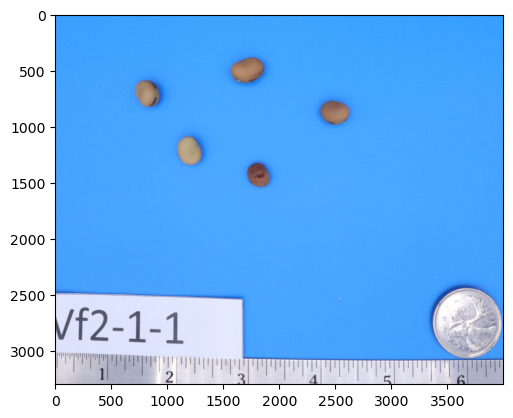

In [3]:
#crop the portion having colorcard for eliminating masks of colorcard. 
image = crop(image, ((2200, 500), (0, 0), (0,0)), copy=False)
plt.figure()
plt.imshow(image)

In [4]:
#open the .csv file from the path to the the metadata file 

df_metadata=pd.read_csv(r"C:\Users\bargotah\Downloads\output_cropmask\Faba-Seed-CC_Vf2-1-1\metadata.csv")

In [5]:
#check the first 5 rows of dataframe
print (df_metadata.head(5))

   id      area  bbox_x0  bbox_y0  bbox_w  bbox_h  point_input_x  \
0   0    888445        0     2491    1677     581          812.5   
1   1  10724430        0       11    3999    3069         2562.5   
2   2    302099     3374     2444     614     625         3437.5   
3   3    902079        0     3022    3999     275           62.5   
4   4     51271     1571      387     294     226         1812.5   

   point_input_y  predicted_iou  stability_score  crop_box_x0  crop_box_y0  \
0      3042.1875       1.048182         0.988229            0            0   
1       979.6875       1.043932         0.991445            0            0   
2      2939.0625       1.014352         0.992704            0            0   
3      3042.1875       1.010107         0.981325            0            0   
4       567.1875       1.001935         0.992579            0            0   

   crop_box_w  crop_box_h  
0        4000        3300  
1        4000        3300  
2        4000        3300  
3        4

#### Find the mask of coin:
The metadata file contains the coordinates of each object detected by SAM. The masks would be for seeds, scale, coin, colorcard. For standardization purposes, mask of coin has to be used and seperated from the masks of seeds. Since the coin lies towards the end of extreme right part of the image where coordinate of x on x-axis is greater than 3300 and the area of coin is greater than 200000, therefore the mask of coin is selected based on the position and area of the coin.

In [6]:
# dataframe for coin required for standardization of area, length and breath
df_metadata_coin = df_metadata[(df_metadata['bbox_x0'] >= 3300) & (df_metadata['area'] >= 200000)]
print (df_metadata_coin)

   id    area  bbox_x0  bbox_y0  bbox_w  bbox_h  point_input_x  point_input_y  \
2   2  302099     3374     2444     614     625         3437.5      2939.0625   

   predicted_iou  stability_score  crop_box_x0  crop_box_y0  crop_box_w  \
2       1.014352         0.992704            0            0        4000   

   crop_box_h  
2        3300  


In [7]:
#check the index of coin mask and filter the mask from all the SAM masks
Mask_index= df_metadata_coin.index.tolist() #check the index

print ('index of coin mask is ', Mask_index)

#masks_coin=[masks_SAM[x] for x in Mask_index] # Filter the mask for subsequent use for standardization. 

index of coin mask is  [2]


### Find the masks of beans
The remaining masks (other than the masks of coin) are the masks of seeds, label and scale. The masks of particular objects have been filtered based on the coordinates of bounding boxes of objects. The masks of label, scale, coin and duplicate masks will be dropped to get the masks of beans. The masks where bbox_h and bbox_w are greater than or equal to 650 have too been removed. This is due to the fact that the average size of bounding box according to the size of seeds is >/= 650. Some of the seeds are too small that 2 seeds get detected in a single box. To avoid duplicacy of the data for the seeds, the duplicate masks containing 2 or more seeds have been removed. 

In [8]:

conditions = [
    (df_metadata['bbox_x0'] <= 1900) & (df_metadata['bbox_y0'] >= 2500), #label
    (df_metadata['bbox_x0'] <= 4000) & (df_metadata['bbox_y0'] >= 3000), #Scale
    (df_metadata['bbox_x0'] >= 3300) & (df_metadata['bbox_y0'] >= 2400), #coin
    (df_metadata['bbox_h'] >= 650), #duplicate mask for seed
    (df_metadata['bbox_w'] >= 650) #duplicate mask for seed
]

for condition in conditions:
    df_metadata = df_metadata.drop(df_metadata[condition].index)
print (df_metadata)

   id   area  bbox_x0  bbox_y0  bbox_w  bbox_h  point_input_x  point_input_y  \
4   4  51271     1571      387     294     226         1812.5       567.1875   
5   5  33333     1715     1329     203     212         1812.5      1495.3125   
6   6  43033     1091     1091     220     253         1187.5      1082.8125   
7   7  42403     2371      773     256     210         2437.5       876.5625   
9   9  40370      715      591     218     235          812.5       773.4375   

   predicted_iou  stability_score  crop_box_x0  crop_box_y0  crop_box_w  \
4       1.001935         0.992579            0            0        4000   
5       0.997837         0.992349            0            0        4000   
6       0.996393         0.990382            0            0        4000   
7       0.993821         0.991711            0            0        4000   
9       0.980394         0.990217            0            0        4000   

   crop_box_h  
4        3300  
5        3300  
6        3300  
7   

In [9]:
print (df_metadata_coin)

   id    area  bbox_x0  bbox_y0  bbox_w  bbox_h  point_input_x  point_input_y  \
2   2  302099     3374     2444     614     625         3437.5      2939.0625   

   predicted_iou  stability_score  crop_box_x0  crop_box_y0  crop_box_w  \
2       1.014352         0.992704            0            0        4000   

   crop_box_h  
2        3300  


### Calculation of calibration factor for standardization using mask of coin

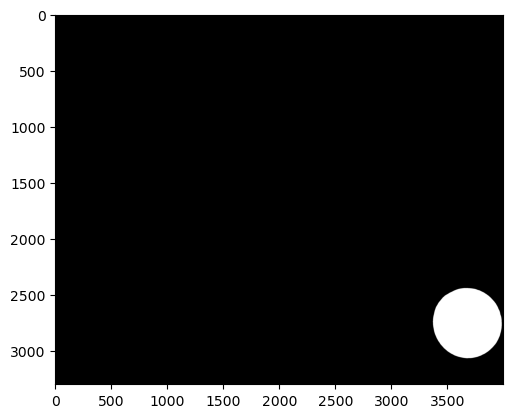

In [10]:
#Get the required mask according to the mask index checked above
mask_coin=cv2.imread(r"C:\Users\bargotah\Downloads\output_cropmask\Faba-Seed-CC_Vf2-1-1\2.png")
plt.figure()
plt.imshow(mask_coin)

In [11]:
mask_coin.shape

(3300, 4000, 3)

### Note: The mask generated by SAM have been saved and read using opencv2. Therefore the mask is 3D channels in shape. The mask has to be convereted to 2D channels because the properties in regionprops (skimage.measure) requires 2D channels and it will give an error if the 3D mask is used. The SAM mask generated has been converted to grayscale for ensuring the 2D channels.

### Please note that this is not the case with the iteration loop as in used in the pipeline. In the pipeline, the masks generated are 2D in shape and can be used as such (no need for conversion to grayscale) for labelling and measuring the properties. 


In [12]:
#Conversion to grayscale image
binary=cv2.cvtColor(mask_coin, cv2.COLOR_BGR2GRAY)
binary.shape


(3300, 4000)

In [13]:
from skimage import measure
from skimage.measure import label, regionprops, regionprops_table

#Label the mask
#Reference: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_label.html
label_image = measure.label(binary)

#analyse masks
#Reference: https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops
props = regionprops_table(label_image,properties=('area','perimeter','axis_major_length', 'axis_minor_length')) 

# convert to dataframe
coin_std = pd.DataFrame(props)



In [14]:
print (coin_std)

       area    perimeter  axis_major_length  axis_minor_length
0  302099.0  2055.647978         629.060034         611.481525


### Calibration factor for Area

In [15]:
Length_coin_mm=23.88
width_coin_mm=23.88

Area_standard_coin_pixels= coin_std.iloc[0]['area'] # Area of coin in pixels
Area_Standard_coin_mm2=3.14*(Length_coin_mm/2)*(Length_coin_mm/2) # Area of coin in mm2
Calibration_factor_area=(Area_Standard_coin_mm2/Area_standard_coin_pixels) # Calibration factor for area
print ('Calibration factor for area :', Calibration_factor_area)

Calibration factor for area : 0.0014817980330951112


### Calibration factor for length

In [16]:
axis_major_length_pixels= coin_std.iloc[0]['axis_major_length'] # Length of coin in pixels
Calibration_factor_length=(Length_coin_mm/axis_major_length_pixels) # Calibration factor for length
print ('Calibration factor for length :', Calibration_factor_length)

Calibration factor for length : 0.037961400695212276


### Calibration factor for Width

In [17]:
axis_minor_length_pixels= coin_std.iloc[0]['axis_minor_length'] # Width of coin in pixels
Calibration_factor_width=(width_coin_mm/axis_minor_length_pixels) # Calibration factor for width
print ('Calibration factor for Width :', Calibration_factor_width)

Calibration factor for Width : 0.039052692534502824


### Calibration factor for Perimeter

In [18]:
perimeter_mm =(2*3.14*Length_coin_mm)/2
perimeter_pixels= coin_std.iloc[0]['perimeter'] # perimeter of coin in pixels
Calibration_factor_perimeter=(perimeter_mm/perimeter_pixels) # Calibration factor for perimeter
print ('Calibration factor for Perimeter :', Calibration_factor_perimeter)

Calibration factor for Perimeter : 0.03647667343110602


### Feature extraction in pixels and millimeter units from masks of seeds

In [19]:
#get the required masks of seeds from filtration step
Masks_list=df_metadata.index.tolist()
print (Masks_list)

#masks_SAM=[masks_SAM[x] for x in Masks_list]

[4, 5, 6, 7, 9]


      area  eccentricity  equivalent_diameter_area   perimeter  solidity  \
0  51271.0      0.709047                255.500029  867.193001  0.994414   
0  33333.0      0.569641                206.011878  688.239682  0.992467   
0  43033.0      0.588840                234.075452  782.565584  0.993994   
0  42403.0      0.600484                232.355711  775.595021  0.994558   
0  40370.0      0.576472                226.717182  754.281313  0.993968   

   area_convex    extent  axis_major_length  axis_minor_length   Area_mm2  \
0      51559.0  0.765639         304.606113         214.796309  75.973267   
0      33586.0  0.767122         227.486513         186.969686  49.392774   
0      43293.0  0.766612         260.621935         210.647507  63.766215   
0      42635.0  0.781954         260.036615         207.934754  62.832682   
0      40615.0  0.781093         250.944237         205.050703  59.820187   

   Length_mm2  Width_mm2  perimeter_mm2  Aspect_Ratio  Roundness_mm  
0   11.563

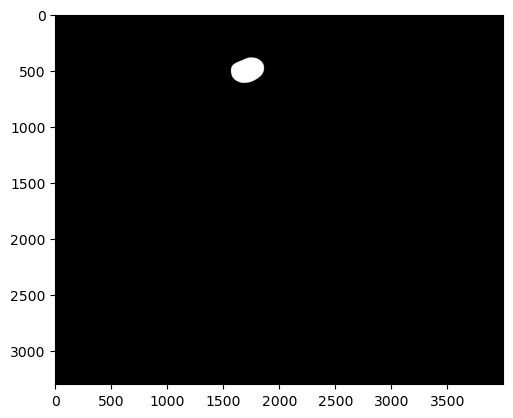

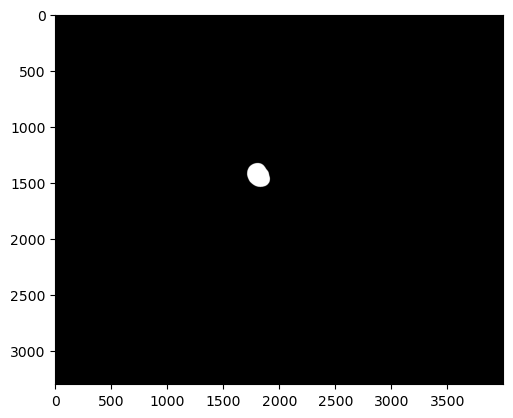

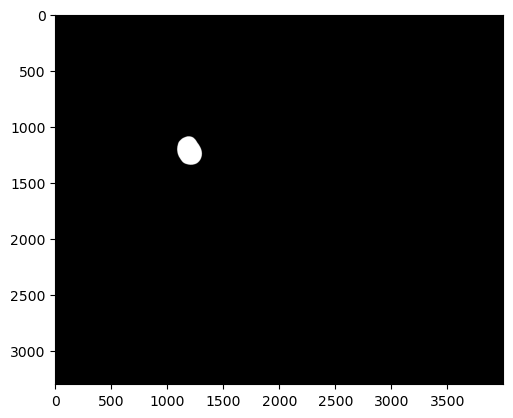

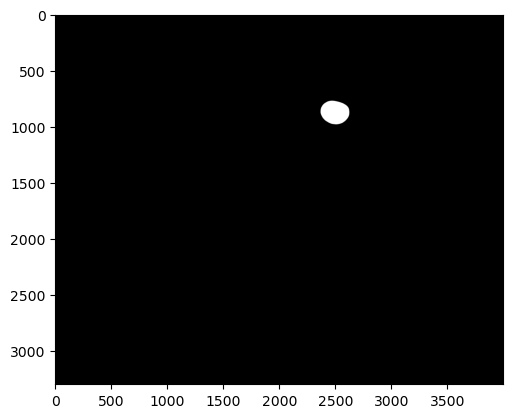

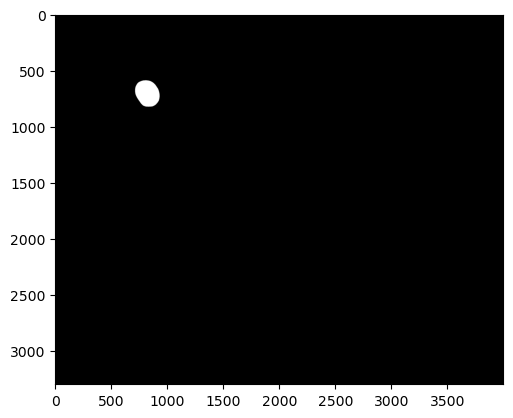

In [20]:
import os
#for selected masks
Masks_list=df_metadata.index.tolist()

df_list=[]
# Folder containing the images
folder_path = r"C:\Users\bargotah\Downloads\output_cropmask\Faba-Seed-CC_Vf2-1-1"
for i in Masks_list:
    # Loop through the list and plot each mask
#for number in l:
    filename = f"{i}.png"  # Construct the filename
    file_path = os.path.join(folder_path, filename)  # Construct the full file path
    mask=cv2.imread(file_path)
    plt.figure()
    plt.imshow(mask)
    binary=cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    label_image = measure.label(binary)
    props = regionprops_table(label_image,properties=( ('area','eccentricity', 'equivalent_diameter_area','perimeter','solidity', 'area_convex', 'extent','axis_major_length', 'axis_minor_length'))) #properties = measure.regionprops(label_image, intensity_image=image)
    df_FE = pd.DataFrame(props)
    df_FE["Area_mm2"]=df_FE["area"] * Calibration_factor_area
    df_FE["Length_mm2"]=df_FE["axis_major_length"] * Calibration_factor_length
    df_FE["Width_mm2"]=df_FE["axis_minor_length"] * Calibration_factor_width
    df_FE["perimeter_mm2"]=df_FE["perimeter"] * Calibration_factor_perimeter
    df_FE["Aspect_Ratio"] = df_FE["axis_major_length"]/df_FE['axis_minor_length']
    df_FE["Roundness_mm"]= (4*3.14*(df_FE["Area_mm2"]))/((df_FE["perimeter_mm2"])**2)
    df_list.append(df_FE)
    df_FE2 = pd.concat(df_list)
print(df_FE2)

### The resultant dataframe contains all the features extracted in pixels and in millimeter units.

In [21]:
#The resultant dataframe can be exported to .csv file for further analysis
